In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import uniform_filter1d  # For smoothing

# Define the base directory and experiment names
base_dir = "results/State-Vis-Pretraining/MiniGrid/Empty-8x8-v0"
experiments = [ "PPO_VanillaGPU", "PPO_AE_Offline_NO_Freeze", "PPO_AE_Offline_CNN_Freeze",
                "PPO_IMDP_Offline_CNN_Part_Freeze",
                "PPO_LMDP_Offline_Hinge", "PPO_LMDP_Offline_Hinge_transition",
                "PPO_LMDP_Offline_Hinge_W2"
                ]

# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {exp: [] for exp in experiments}
episode_lengths = {exp: [] for exp in experiments}
steps = {exp: [] for exp in experiments}  # To store step numbers

# Read data from CSV files
for exp in experiments:
    for seed in range(1, num_seeds + 1):
        file_path = os.path.join(base_dir, exp, f"seed-{seed}", "train.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            episode_rewards[exp].append(df['true_episode_reward'])
            episode_lengths[exp].append(df['episode_length'])
            steps[exp].append(df['step'].values)  # Read step numbers
        else:
            print(f"File not found: {file_path}")

# Align data to the length of the longest seed for each experiment
def align_data(data):
    max_length = max(len(seed_data) for seed_data in data)
    aligned_data = []
    for seed_data in data:
        if len(seed_data) < max_length:
            # Repeat the last value to match the length of the longest seed
            aligned_data.append(np.pad(seed_data, (0, max_length - len(seed_data)), mode='edge'))
        else:
            aligned_data.append(seed_data)
    return np.array(aligned_data)

aligned_episode_rewards = {exp: align_data(episode_rewards[exp]) for exp in experiments}
aligned_episode_lengths = {exp: align_data(episode_lengths[exp]) for exp in experiments}
aligned_steps = {exp: align_data(steps[exp]) for exp in experiments}

# Compute mean and standard error for each experiment
def compute_stats(data):
    mean = np.mean(data, axis=0)
    std_error = sem(data, axis=0)
    return mean, std_error

episode_rewards_stats = {exp: compute_stats(aligned_episode_rewards[exp]) for exp in experiments}
episode_lengths_stats = {exp: compute_stats(aligned_episode_lengths[exp]) for exp in experiments}
steps_stats = {exp: compute_stats(aligned_steps[exp]) for exp in experiments}

# Smoothing function using a moving average
def smooth_data(data, window_size=10):
    """Apply a moving average to smooth the data."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Plotting function
def plot_results(stats, steps_stats, ylabel, title, filename, window_size=10):
    plt.figure(figsize=(12, 6))
    for exp in experiments:
        mean, std_error = stats[exp]
        step_mean, _ = steps_stats[exp]  # Use step numbers for the x-axis

        # Smooth the mean and std_error
        smoothed_mean = smooth_data(mean, window_size)
        smoothed_std_error = smooth_data(std_error, window_size)

        plt.plot(step_mean, smoothed_mean, label=exp)
        plt.fill_between(step_mean, smoothed_mean - smoothed_std_error, smoothed_mean + smoothed_std_error, alpha=0.2)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename+".png")
    plt.show()


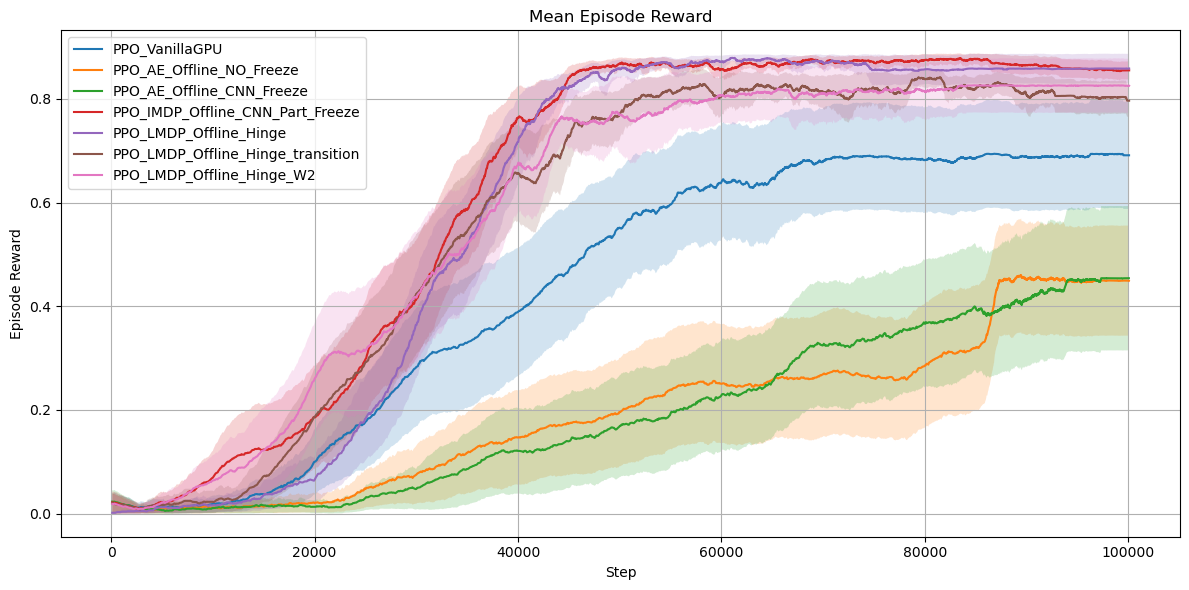

In [13]:
# Plot episode rewards
plot_results(episode_rewards_stats, steps_stats, 
             'Episode Reward', 'Mean Episode Reward', 
             filename="plot_episode_reward", window_size=50)

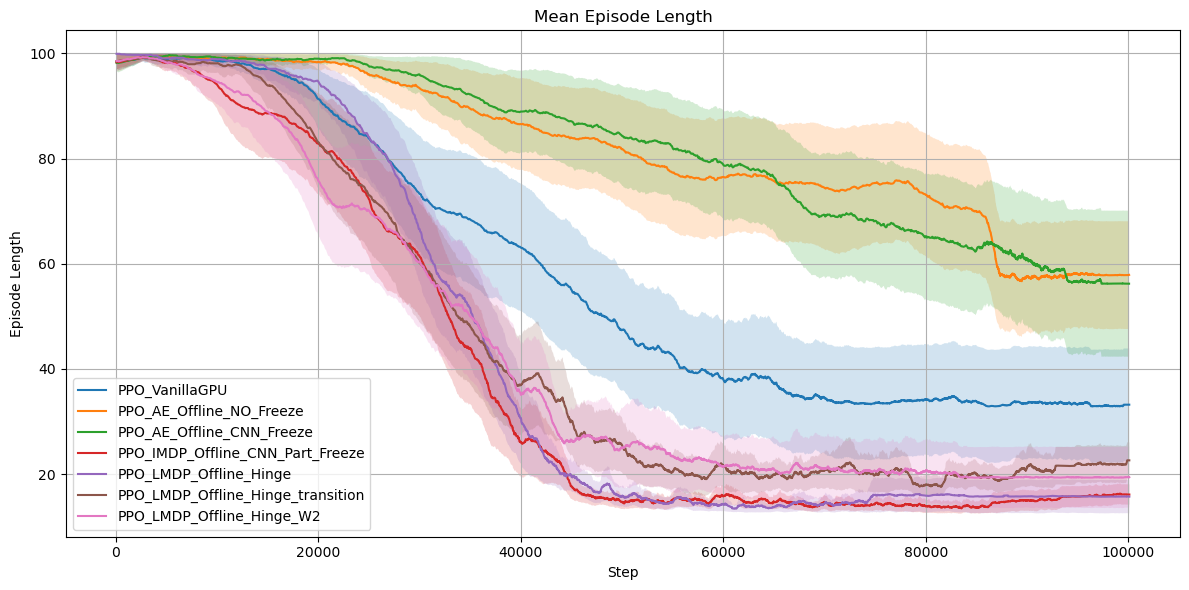

In [14]:
# Plot episode lengths
plot_results(episode_lengths_stats, steps_stats, 
             'Episode Length', 'Mean Episode Length', 
             filename="plot_episode_length", window_size=50)